# Iterative-RAKI for inline calibration 
This notebook reconstructs a 4-fold undersampled 2D image. As training data, 18 central lines (auto-calibration-signals, ACS) are used. 

For comparison, it also provides a GRAPPA and standard RAKI reconstruction.

In [1]:
import numpy as np 
import sigpy as sp
import pathlib

from matplotlib import pyplot as plt

from cnn.rakiModels import rakiReco, irakiReco
from grappa.grappaReco import grappa
from utils.metrics import nmse, ssim, psnr
from utils.coilMapping import getMask

First, the fully-sampled k-space and the undersampling mask is loaded. This code assumes multi-channel 2D k-space in shape (coils, PE, RO), with PE: Phase-Encoding direction and RO: Read-Out direction.

In [2]:
DATADIR = pathlib.Path('./data/') # directory to k-space data and sampling mask
assert DATADIR.is_dir(), 'expected data directory non-existent'
file_name = 'neuro0' # file name of fully-sampled kspace 

use_vcc = 0 # flag to use virtual-conjugate-coils for phase constraint reconstruction 
acs_flag = 1 # for inline calibration, the acs is put back into reconstructed k-space 

kspace_fs = np.load(DATADIR / (file_name + '.npy'))  # fully-sampled k-space
if use_vcc:
    kspace_fs = np.concatenate((kspace_fs, np.conjugate(np.flip(np.flip(kspace_fs,axis=1),axis=2))),axis=0)

# check k-space scaling such that minimum signal has order of magnitude 0     
scaling = np.floor(np.log10(np.min(np.abs(kspace_fs[np.where(kspace_fs!=0)]))))
kspace_fs *= 10**(-1*int(scaling))

ipat = np.load(DATADIR / (file_name + '_ipat.npy')) # undersampling mask 

In [3]:
acq = np.where(ipat[:,0]==1)[0] # get index of first non-zero sample

kspace_fs = kspace_fs[:,acq[0]:,:] # the code does not allow for leading zeros in k-space 
ipat = ipat[acq[0]:,:]

(nC, nP, nR) = kspace_fs.shape # (coils, number phase encoding lines, number read out lines)

R = acq[1] - acq[0] # acceleration factor 

kspace_zf = np.zeros_like(kspace_fs) # generate zero-filled kspace without acs  
kspace_zf[:,::R,:] = kspace_fs[:,::R,:]

Lets visualize the undersampled image and the k-space sampling mask. 

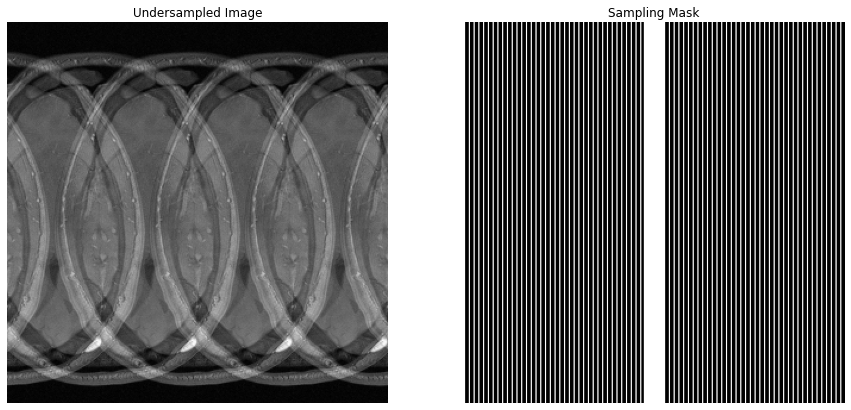

In [4]:
img_zf = sp.rss(sp.ifft(kspace_zf,axes=[1,2]),0)
fig, axs = plt.subplots(1,2, figsize=[15,30])
axs[0].imshow(np.abs(np.rot90(img_zf)),cmap='gray')
axs[1].imshow(np.rot90(ipat),cmap='gray')
axs[0].set_title('Undersampled Image')
axs[1].set_title('Sampling Mask')
for jj in range(2):
    axs[jj].axis('off')

Lets get the ACS from the center of the fully sampled k-space. For 4-fold undersampling, we use 18 ACS lines.

In [5]:
acq_conti = np.where(acq[1:]-acq[:-1]==1)[0] 

acs_start = acq[acq_conti[0]]
acs_end = acq[acq_conti[-1]]+1
acs = kspace_fs[:,acs_start:acs_end+1,:]
(_,nP_acs, nR_acs) = acs.shape 

R_eff = ((((nP-nP_acs)/R)+nP_acs)/nP)**-1
print('Acceleration Factor: ', str(R), '\n', 'Number ACS Lines: ', str(nP_acs), '/', str(nP), '\n', 'Effective Acceleration Factor: ', '{:.2f}'.format(R_eff))

Acceleration Factor:  4 
 Number ACS Lines:  18 / 320 
 Effective Acceleration Factor:  3.42


Now we build the RAKI-Network. The dictionary 'layer_design_raki' specifies its architechture.  

In [6]:
layer_design_raki = {'num_hid_layer': 2, # number of hidden layers, in this case, its 2
                    'input_unit': nC,    # number channels in input layer, nC is coil number 
                        1:[256,(2,5)],   # the first hidden layer has 256 channels, and a kernel size of (2,5) in PE- and RO-direction
                        2:[128,(1,1)],   # the second hidden layer has 128 channels, and a kernel size of (1,1) in PE- and RO-direction
                    'output_unit':[(R-1)*nC,(1,5)] # the output layer has (R-1)*nC channels, and a kernel size of (1,5) in PE- and RO-direction
                    }

raki_reco = rakiReco(np.copy(kspace_zf), acs, R, layer_design_raki) # get standard RAKI reconstruction

if acs_flag: # put ACS back into reconstructed k-space
    raki_reco[:, acs_start:acs_end+1, :] = acs

Starting Standard RAKI...


100%|██████████| 500/500 [01:45<00:00,  4.75it/s]


Finished Standard RAKI...


Now lets do the GRAPPA reconstruction.

In [7]:
grappa_reco = grappa(np.copy(kspace_zf), acs, R, {'phase':2, 'read':5} , 0.0001)

if acs_flag:
    grappa_reco[:, acs_start:acs_end+1,:] = acs

Loading Source - & Target Matrix ... 
Done 

Took  0.021  sec 

GRAPPA Weights Calculation...
Done 

Took  0.26 sec 



For iterative-RAKI, the kernel size assigned to the first hidden layer is increased from (2,5) to (4,7) in PE- and RO-direction.

In [8]:
layer_design_iraki = {'num_hid_layer': 2, # number of hidden layers, in this case, its 2
                     'input_unit': nC,    # number channels in input layer, nC is coil number 
                         1:[256,(4,7)],   # the first hidden layer has 256 channels, and a kernel size of (4,7) in PE- and RO-direction
                         2:[128,(1,1)],   # the second hidden layer has 128 channels, and a kernel size of (1,1) in PE- and RO-direction
                    'output_unit':[(R-1)*nC,(1,5)]  # the output layer has (R-1)*nC channels, and a kernel size of (1,5) in PE- and RO-direction
                     }
iraki_reco = irakiReco(np.copy(kspace_zf), acs, R, layer_design_iraki, grappa_reco, acs_flag, acs_start, acs_end) 


  0%|          | 0/500 [00:00<?, ?it/s]

Starting Iterative RAKI...
Iteration  1  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  2  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  3  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  4  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  5  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  6  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  7  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  8  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  9  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  10  of  16


  0%|          | 1/250 [00:00<00:38,  6.46it/s]

Iteration  11  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  12  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  13  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  14  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  15  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  16  of  16


100%|██████████| 250/250 [00:59<00:00,  4.22it/s]


Finished Iterative RAKI...


A mask is computed using ESPIRiT to allow for a more valid estimation of numeric quality metrics. 

In [9]:
msk = getMask(kspace_fs)

EspiritCalib: 100%|██████████| 100/100 [00:05<00:00, 19.06it/s]


     GRAPPA RAKI iRAKI
NMSE 59.6   45.2   32.1
PSNR 36.2   37.4   38.9
SSIM 89.8   92.7   94.0


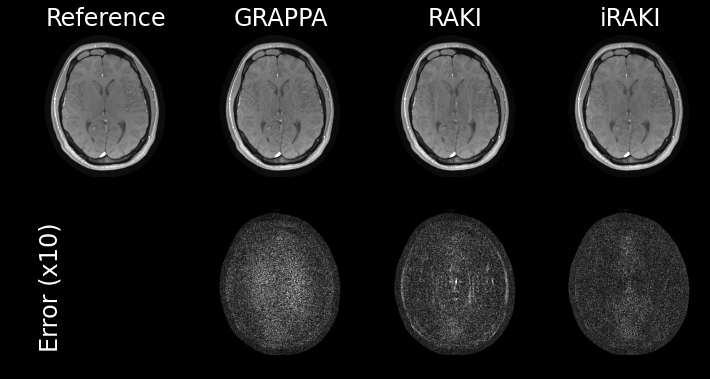

In [10]:
reference = sp.ifft(kspace_fs, axes=[1,2])
reference = sp.rss(reference, 0)
reference = reference * msk
diff_reference = np.abs(reference - reference)

raki_recoFFT = sp.ifft(raki_reco, axes=[1, 2])
raki_recoFFT = sp.rss(raki_recoFFT, 0)  
raki_recoFFT = raki_recoFFT * msk
diff_raki = np.abs(reference - raki_recoFFT)
nmse_raki = nmse(reference, raki_recoFFT)
psnr_raki = psnr(reference, raki_recoFFT)
ssim_raki = ssim(reference, raki_recoFFT)

grappa_recoFFT = sp.ifft(grappa_reco, axes=[1, 2])
grappa_recoFFT = sp.rss(grappa_recoFFT, 0)  
grappa_recoFFT = grappa_recoFFT * msk
diff_grappa = np.abs(reference - grappa_recoFFT)
nmse_grappa = nmse(reference, grappa_recoFFT)
psnr_grappa = psnr(reference, grappa_recoFFT)
ssim_grappa = ssim(reference, grappa_recoFFT)

iraki_recoFFT = sp.ifft(iraki_reco, axes=[1, 2])
iraki_recoFFT = sp.rss(iraki_recoFFT, 0)  
iraki_recoFFT = iraki_recoFFT * msk
diff_iraki = np.abs(reference - iraki_recoFFT)
nmse_iraki = nmse(reference, iraki_recoFFT)
psnr_iraki = psnr(reference, iraki_recoFFT)
ssim_iraki = ssim(reference, iraki_recoFFT)

max_rss = np.max(np.abs(reference))
alpha = 0.6
diffScaling = 1e1

font = {'fontsize':24, 'color': 'white'}
fig, axs = plt.subplots(2,4,figsize=[12,6], facecolor='k')
axs[0,0].imshow(np.abs(np.rot90(reference)), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[0,1].imshow(np.abs(np.rot90(grappa_recoFFT)), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[0,2].imshow(np.abs(np.rot90(raki_recoFFT)), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[0,3].imshow(np.abs(np.rot90(iraki_recoFFT)), cmap='gray', vmin=0, vmax=max_rss*alpha)

axs[1,0].imshow(np.abs(np.rot90(diff_reference*diffScaling)), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[1,1].imshow(np.abs(np.rot90(diff_grappa*diffScaling)), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[1,2].imshow(np.abs(np.rot90(diff_raki*diffScaling)), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[1,3].imshow(np.abs(np.rot90(diff_iraki*diffScaling)), cmap='gray', vmin=0, vmax=max_rss*alpha)

axs[0,0].set_title('Reference', fontdict=font)
axs[0,1].set_title('GRAPPA', fontdict=font)
axs[0,2].set_title('RAKI', fontdict=font)
axs[0,3].set_title('iRAKI', fontdict=font)
axs[1,0].text(10,300, 'Error (x10)', rotation=90, fontdict=font)

print(4*' ', 'GRAPPA', 'RAKI', 'iRAKI')
print('NMSE', str(np.around(1e4*nmse_grappa,1)),' ',str(np.around(1e4*nmse_raki,1)),' ',str(np.around(1e4*nmse_iraki,1)))
print('PSNR', str(np.around(psnr_grappa,1)),' ',str(np.around(psnr_raki,1)),' ',str(np.around(psnr_iraki,1)))
print('SSIM', str(np.around(1e2*ssim_grappa,1)),' ',str(np.around(1e2*ssim_raki,1)),' ',str(np.around(1e2*ssim_iraki,1)))
